<a href="https://colab.research.google.com/github/MananShukla7/Pytorch-CV/blob/main/05_Custom_Datasets_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

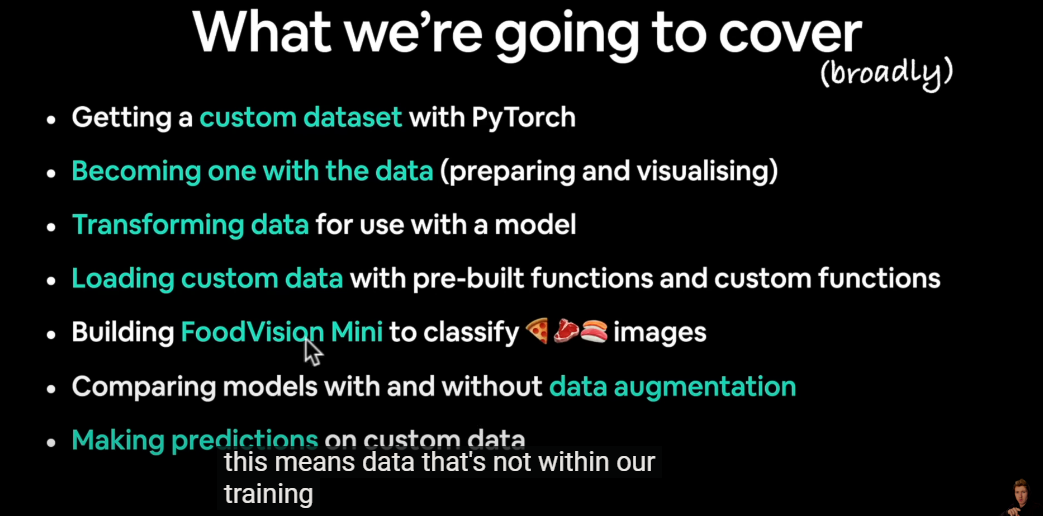

##0. Setting up the Pytorch And importing libraries

In [ ]:
import torch
from torch import nn
torch.__version__

'1.13.1+cu116'

In [ ]:
#Setting up the device agnostics

device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

##1. Getting our data

Our dataset is the subset of the food101 dataset

Our dataset starts with 101 different class of food and 1000 images per class(750 training, 250 testing)

why do this??

Start smol , test and then scale!!

In [ ]:
import requests
import zipfile
from pathlib import Path

data_path=Path("data/")
image_path=data_path/"pizza_steak_sushi"

#if the image folder doesnt exist, download it and prepare it...

if image_path.is_dir():
  print(f"{image_path} directory already exists..skipping download")
else:
  print(f"{image_path} doesn't exist!,Creating one")
  image_path.mkdir(parents=True,exist_ok=True)

#Download
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
  request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("downlaoding the pizza,steak and sushi data ....")
  f.write(request.content)

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip") as zip_ref:
  print("UNzipping the data....")
  zip_ref.extractall(image_path) #PosixPath('data/pizza_steak_sushi')

data/pizza_steak_sushi doesn't exist!,Creating one
downlaoding the pizza,steak and sushi data ....
UNzipping the data....


In [ ]:
image_path  

PosixPath('data/pizza_steak_sushi')

## 2. Becoming one with the data!

In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""

  for dirpath,dirnames,filenames in os.walk(dir_path): 
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in'{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in'data/pizza_steak_sushi'.
There are 3 directories and 0 images in'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in'data/pizza_steak_sushi/test/steak'.


In [ ]:
train_dir=image_path/"train"
test_dir=image_path/"test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

##2.1 visualising an image

Let's wrote some code to:
1. Get all of the ikage paths
2. Pick a random image path using python's random.choice()
3. Get the image class name `pathlib.Path.parent.stem`
4.Since we're working with images,let's open it with python PIL 
5. We'll then show the image and print the metadeta


pizza
Random image path:data/pizza_steak_sushi/train/pizza/1899785.jpg
Image class:pizza
Image heightL 512
Image width: 512


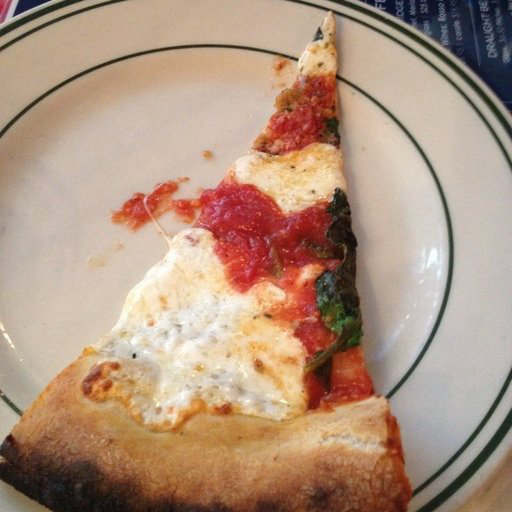

In [ ]:
import random
from PIL import Image
# Set seed
# random.seed(42)


image_path_list=list(image_path.glob("*/*/*.jpg"))

# image_path_list

#2. Pick a random image path

random_image_path=random.choice(image_path_list)

random_image_path

#3. Get image flass from path name 
# (the image class is the name of the directory where the image is stored)
image_class=random_image_path.parent.stem
print(image_class)

#4.open image using PIL

img=Image.open(random_image_path)
#5. Print metadata 
print(f"Random image path:{random_image_path}")
print(f"Image class:{image_class}")
print(f"Image heightL {img.height}")
print(f"Image width: {img.width}")
img

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

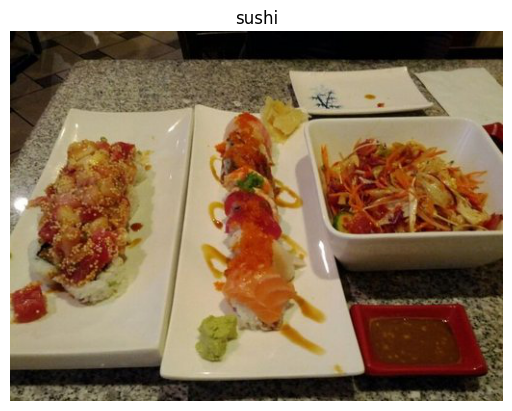

(384, 512, 3)


In [ ]:
#Try to visualize and image with matplotlib

import matplotlib.pyplot as plt

img_list=list(image_path.glob("*/*/*.jpg"))

random_c=random.choice(img_list)
random_c
titlee=random_c.parent.stem
x=plt.imread(random_c)
plt.imshow(x.squeeze());
plt.title(titlee)
plt.axis(False)
plt.show();
print(x.shape) #pytorch oder is cwh-> color width height

In [ ]:
x

array([[[  0,   4,   3],
        [  0,   6,   6],
        [  1,   5,   4],
        ...,
        [ 76,  53,  21],
        [ 81,  58,  26],
        [ 79,  56,  24]],

       [[  0,   2,   2],
        [  0,   3,   3],
        [  0,   2,   1],
        ...,
        [ 79,  56,  24],
        [ 84,  61,  29],
        [ 82,  59,  27]],

       [[  0,   2,   2],
        [  0,   2,   3],
        [  0,   1,   0],
        ...,
        [ 77,  57,  24],
        [ 81,  61,  28],
        [ 80,  60,  27]],

       ...,

       [[103,  98,  58],
        [104,  99,  59],
        [107, 102,  64],
        ...,
        [115, 102,  67],
        [103,  91,  53],
        [ 95,  81,  44]],

       [[103,  98,  58],
        [ 90,  85,  45],
        [ 91,  86,  48],
        ...,
        [115, 103,  65],
        [119, 105,  68],
        [ 92,  78,  41]],

       [[ 88,  83,  43],
        [ 71,  66,  26],
        [ 78,  73,  33],
        ...,
        [117, 105,  67],
        [108,  94,  57],
        [106,  92,  55]]

### 3. Transforming the data

Befire we can use our image data with PyTorch:
1. Turn your target data into tensors(in our case,numerical rep of our data)
2. Turn it into a `torch.utils.data.Datasets` to `torch.utils.data.DataLoader`.


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import ToPILImage
import torchvision.transforms.functional as F


### 3.1 Transforming data with `torchvision.transforms`

In [ ]:
#Write a transform 
data_transform=transforms.Compose([
    #Resize our img
    transforms.Resize(size=(64,64)),
    #Flip the image randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #Transform the img to tensor
    transforms.ToTensor()
])

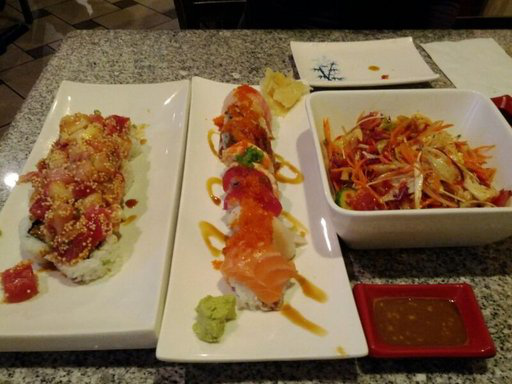

In [ ]:
imgg=F.to_pil_image(x)
imgg

In [ ]:
new_img=data_transform(imgg)

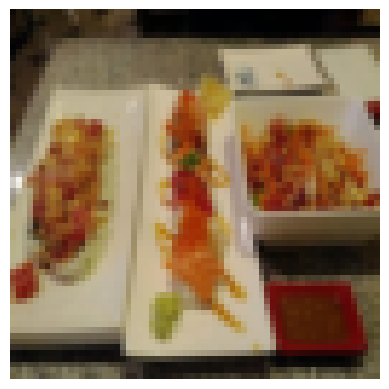

In [ ]:
# y=new_img.numpy().squeeze()
# y.shape
plt.imshow(new_img.permute(1,2,0));
plt.axis(False);

In [ ]:
## Making a function for visualising our tranformed and original data

def plot_transformed_images(image_paths:list,transform,n=3,seed=None):
  """
  Selects random images from the path of images and loads/transforms them then
  plots the original vs the transformed images to see the difference visually!!
  """
  if seed:
    random.seed(seed)
  random_image_paths=random.sample(image_paths,k=n)
  for image_path in random_image_paths:
      with Image.open(image_path) as f:
        plt.figure(figsize=(12,10))

        fig,ax=plt.subplots(1,2)
        ax[0].imshow(f)
        ax[0].set_title(f"Original\nSIze:{f.size}")
        ax[0].axis(False);

        #Transforms and plot target image
        transformed_image=transform(f) #NEeed to convert the cwh to whc for the matplotlib
        ax[1].imshow(transformed_image.permute(1,2,0))
        ax[1].set_title(f"Transformed \nShape: {transformed_image.shape}")
        ax[1].axis(False);

        fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)



  

<Figure size 1200x1000 with 0 Axes>

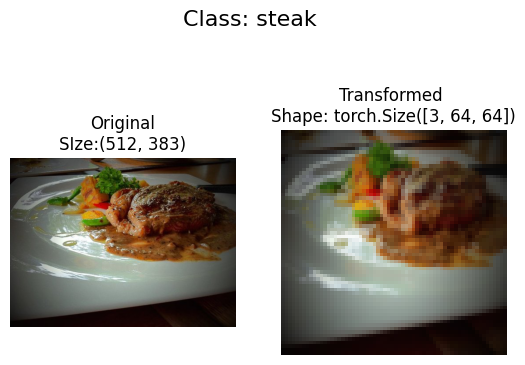

<Figure size 1200x1000 with 0 Axes>

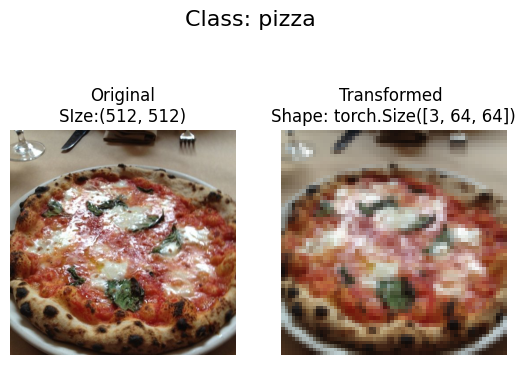

<Figure size 1200x1000 with 0 Axes>

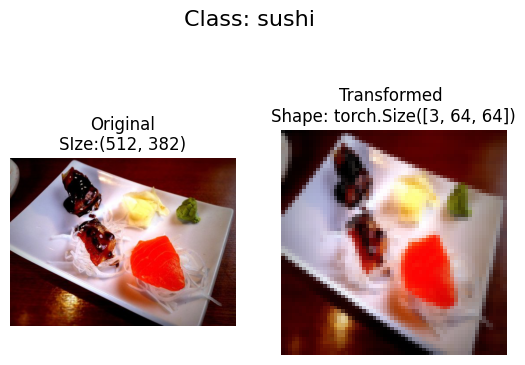

In [ ]:
plot_transformed_images(img_list,data_transform,n=3)

## 4. Opt:1 Loading the image data using the `ImageFolder`

We can load image classification data using the `torchvision.datasets.ImageFolder`

In [ ]:
#Use imagefolder to create dataset(s)

from torchvision import datasets

train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transform, # a transform for the data
                                target_transform=None)

test_data=datasets.ImageFolder(root=test_dir,
                               transform=data_transform)



In [ ]:
train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
#Get class names as list
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
class_dict=train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
#check the length of our data

len(train_data),len(test_data)

(225, 75)

In [ ]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [ ]:
%%capture
train_data[0]

In [ ]:
img,label=train_data[0][0],train_data[0][1]

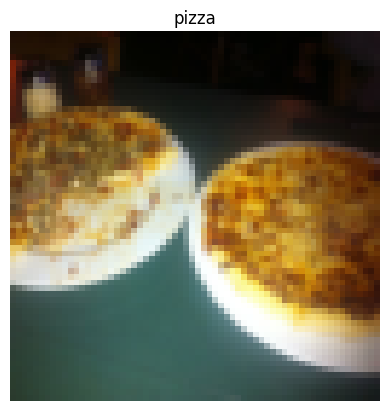

In [ ]:
plt.imshow(train_data[0][0].permute(1,2,0))
# plt.title(class_names[label[train_data[0][1]]])
plt.title(class_names[label]);
plt.axis(False);

In [ ]:
print(f"Image tensor:\n {train_data[0][0]}")
print(f"Image label: {train_data[0][1]}")
print(f"Image dtype: {train_data[0][0].dtype}")
print(f"Image shape: {train_data[0][0].shape}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

In [ ]:
#Changing the c w h  to w h c for visualization
img_permute=img.permute(1,2,0)
img_permute.shape

torch.Size([64, 64, 3])

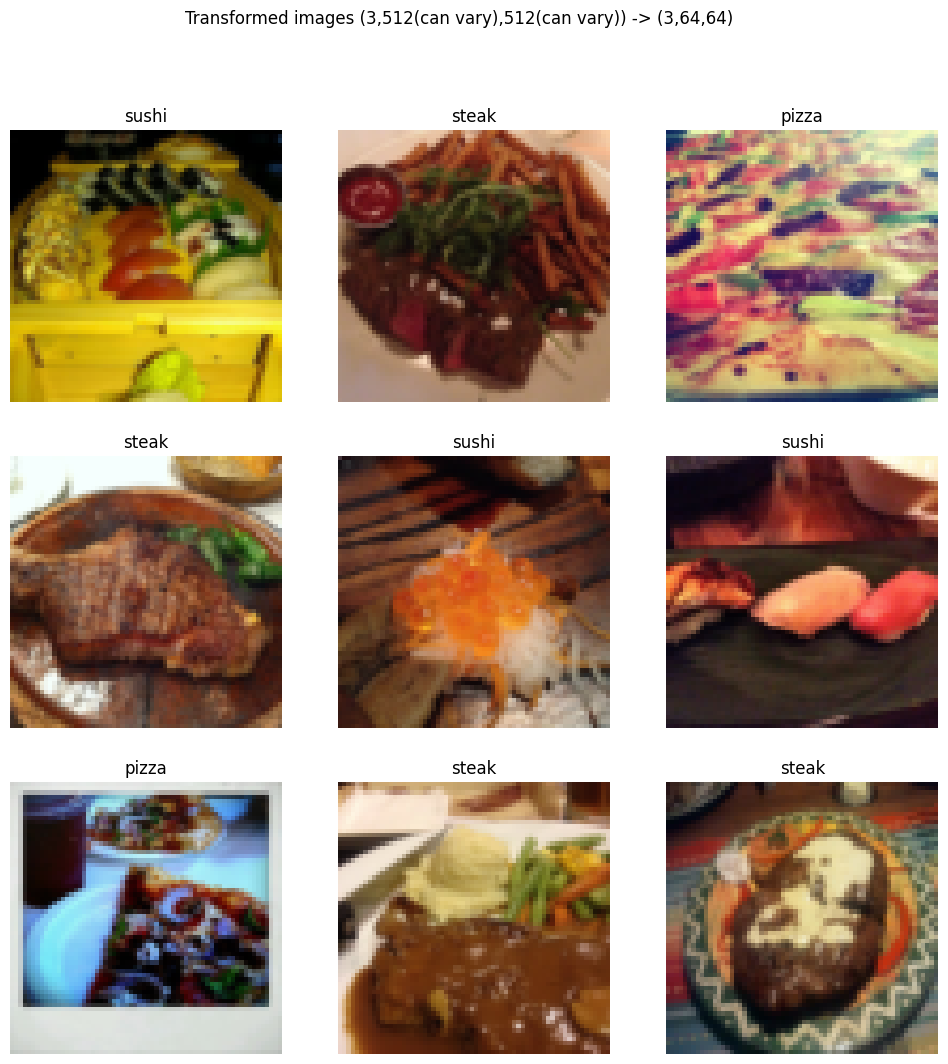

In [ ]:
rows,cols=3,3
plt.figure(figsize=(12,12))
i=1

# for i in range(1,rows*cols+1):
random_sample=torch.randint(0,len(train_data),size=[rows*cols])
for sample in random_sample:
  plt.subplot(rows,cols,i)
  img,label=train_data[sample]
  plt.imshow(img.permute(1,2,0))
  plt.title(class_names[label]);
  plt.suptitle("Transformed images (3,512(can vary),512(can vary)) -> (3,64,64)")
  plt.axis(False);
  i+=1



## 4.1 Turning the images into dataloaders
They are going to help our image tensors dataset to be converted into 
python iterable object and divide our data into batch sizes (pref size 32)
which will help model to look at a batch per iteration.

In [ ]:
import os
os.cpu_count()

2

In [ ]:
from torch.utils.data import DataLoader

train_dataloader=DataLoader(dataset=train_data,
                            batch_size=1,
                            shuffle=True,
                            num_workers=os.cpu_count())

test_dataloader=DataLoader(dataset=test_data,
                            batch_size=1,
                            shuffle=False,
                            num_workers=os.cpu_count())


In [ ]:
train_dataloader.dataset

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [ ]:
img,label=next(iter(train_dataloader))

In [ ]:
img.shape,label.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

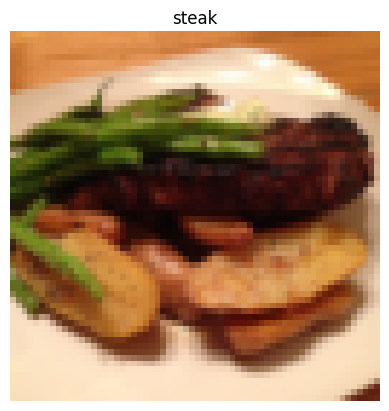

In [ ]:
n=0
for i in img:
  
  plt.imshow(i.permute(1,2,0))
  plt.title(class_names[label[n]])
  plt.axis(False)
  n+=1

In [ ]:
len(train_dataloader),len(test_dataloader)

(225, 75)

## Option 2: Creating a custom datasets!!

- Replicate the functionality of the dataset or imagefolder class
- this should:

    1. be able to get and load images from the file
    2. Be able to get the class names from the dataset
    3. BE able to get the classes as dictionay from the data sets

Pros:
- can create a `Dataset` out of almost anything.
- Not limited to the PyTorch `Dataset` functions

Cons:
- Even though you could create a dataset its not necessary it will work
- Creating custom datasets means writing lots and lots of code and could be prone to errors and performance issues
(Because the functions in the `Dataset` of Pytorch is tested many many MANY times before adding them to the stable release.This testing requires a lot of time ,which can be a constraint while developing a custom dataset).
 

In [ ]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List

In [ ]:
#Instance of the torchvision.datasets.ImageFolder()
train_data.classes,train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

##5.1 Creating a helper function to get class names

We want s func to:
1. Get the class names using `os.scandir()` to traverse ta target directory
2. Raise an error if the class names aren't found(can be something wrong with
the directory struct)
3. Turn the class names into the dict and a list and return them


In [ ]:
#Setup path for target directory
target_directory=train_dir
target_directory

#Get the class names from the target directory
class_names_found=sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

['pizza', 'steak', 'sushi']

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

In [ ]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'sushi'>, <DirEntry 'steak'>]

In [ ]:
class_dict={}
for item,key in enumerate(class_names_found):
  class_dict.update({key:item})
class_dict


{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
#Writing with list comprehension


# class_dict,update({key,item}) for item,key in enumerate(class_names_found)
class_dict={key:item for item,key in enumerate(class_names_found)}

In [ ]:
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
def find_classes(directory:str)->Tuple[List[str],Dict[str,int]]:
  """
  Find the class folder names in the target dir.

  return:
  1. A list of class names.
  2. A dictionary mapped from class names to labels.
  """
  classes=sorted([entry.name for entry in (os.scandir(directory)) if entry.is_dir()])

  #Raise an error if the class names not found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}...please check the file structure or the spelling of the directory passed.")
  class_dict={key:item for item,key in enumerate(classes)}
  return classes,class_dict

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
#TO check if the error handling works or not
trial=Path("trial_path")
trial.mkdir(parents=True,exist_ok=True)

find_classes(trial)

FileNotFoundError: ignored

#Now to fully replicate the ImageFolder!!

### 5.2 CREATE OUR OWN CUSTOM DATASET

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init pur subclass with a target directory as well as a transform if we'd like to transform our data.
3. Create several attributes:
  - paths-Paths of our images
  - transform -the transform we'd like to use
  - classes- a list of target classes
  - class_to_idx- a dict of the target classes mapped to integer labels

4. Create a func to `load_images` this will open an image
5. We want to override the `__len__()` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passes an index


In [ ]:
# Now to write a custom dataset class
from torch.utils.data import Dataset

#1 Subclass torch.utils.data.Dataset

class ImageFolderCustom(Dataset):

  #2 Initialize our custom dataset
  def __init__(self,
               targ_dir:str,
               transform=None):
    #3. Create class attributes
    #Get all of the image paths
    self.paths=list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    #Setup transforms
    self.transform=transform
    #Create a classes and class to idx
    self.classes,self.class_to_idx=find_classes(targ_dir)
  
  #4 create a func to load images
  def load_image(self,idx)->Image.Image:
    "opens an image via path and returns it"

    image_path=self.paths[idx]
    return Image.open(image_path)

  #5 override the __len__()
  def __len__(self)->int:
    "Returns the total no of the samples"
    return len(self.paths)

  #6 Override the __getitem__() method to return a particular sample
  def __getitem__(self,idx:int)->Tuple[torch.Tensor,int]:
    "Recreate img,label=data[0]  returns one sample of (X,y)"
    img=self.load_image(idx)
    class_name=self.paths[idx].parent.name #expects the path in format: data_folder/class_name/image.jpg
    class_idx=self.class_to_idx[class_name]

    #Transform if necessary
    if self.transform:
      return self.transform(img),class_idx #Return data,label(X,y)

    else:
      return img,class_idx #Returns the untransformed data





In [ ]:
#Create a tranform
from torchvision import transforms
train_transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()

])

test_transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()

])

In [ ]:
#Lets test image folder custome class!!
train_data_custom=ImageFolderCustom(train_dir,
                                    train_transform)
test_data_custom=ImageFolderCustom(test_dir,
                                   test_transform)

In [ ]:
#Trying out 
train_data_custom,test_data_custom 


(<__main__.ImageFolderCustom at 0x7f69ae167040>,
 <__main__.ImageFolderCustom at 0x7f69ae167490>)

In [ ]:
train_data #original

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [ ]:
len(train_data),len(train_data_custom)

(225, 225)

In [ ]:
len(test_data),len(test_data_custom)

(75, 75)

In [ ]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check for equality bw the cistom and original
print(train_data.classes==test_data_custom.classes)
print(train_data.classes==test_data_custom.classes)

True
True


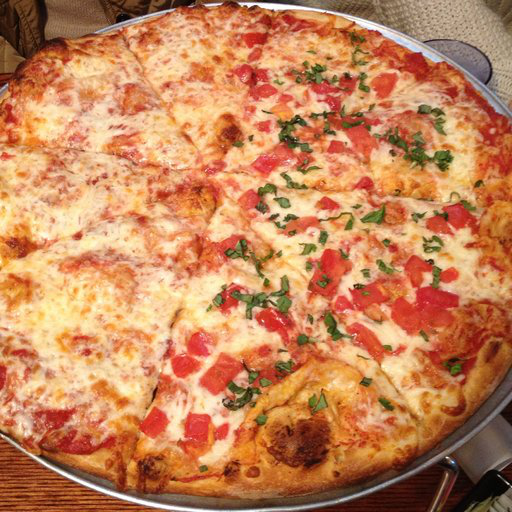

In [ ]:
train_data_custom.load_image(3)

In [ ]:
##%.3 Create a function to display the random images

In [ ]:

def visualize_9_img(data,seed=None):
  if seed:
    torch.manual_seed(seed)

  rows,cols=3,3
  i=1
  plt.figure(figsize=(12,12))
  samples=torch.randint(0,len(data),size=[9])
  for sample in samples:
    img,label=data[sample]
    # print(img.shape)
    plt.subplot(rows,cols,i)
    plt.imshow(img.permute(1,2,0))
    plt.title(class_names[label])
    plt.suptitle(f"Visualizing the data of transformed size(may not be transformed){img.shape}",fontsize=12)
    plt.axis(False);
    i+=1

    



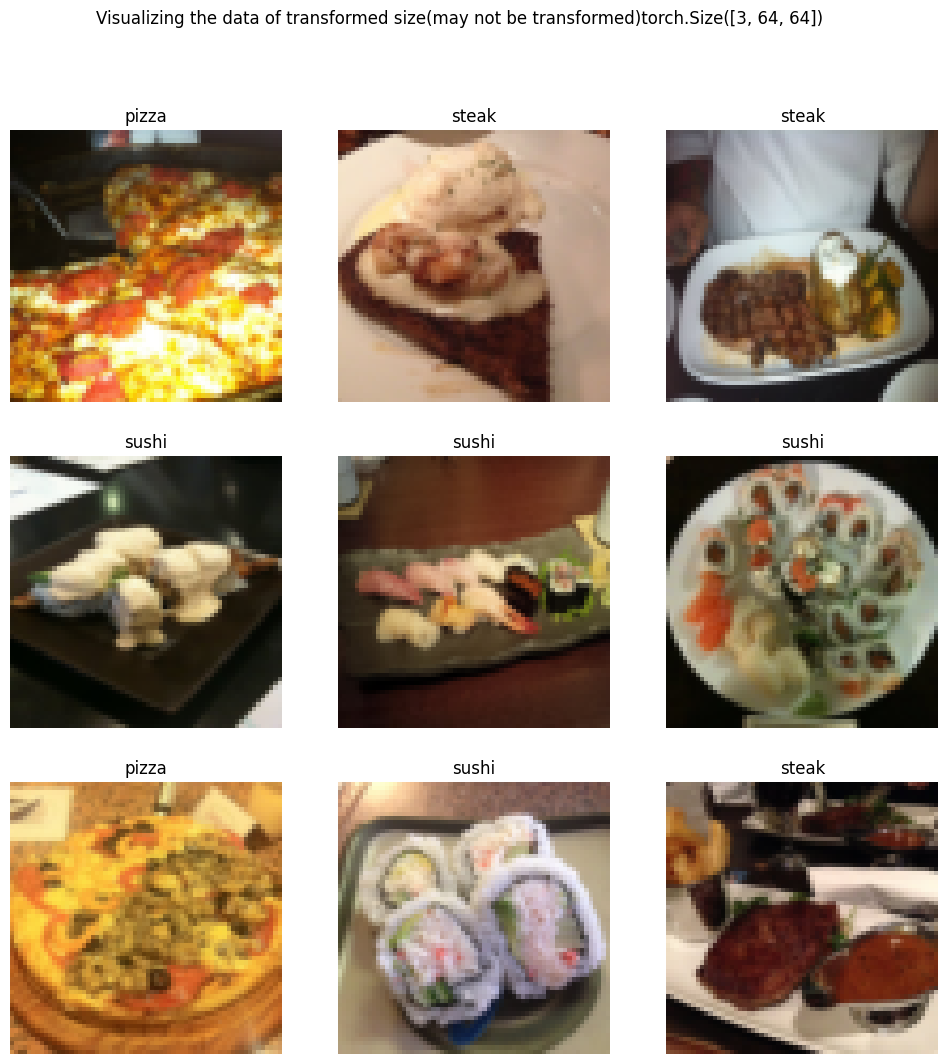

In [ ]:
visualize_9_img(train_data_custom,42)

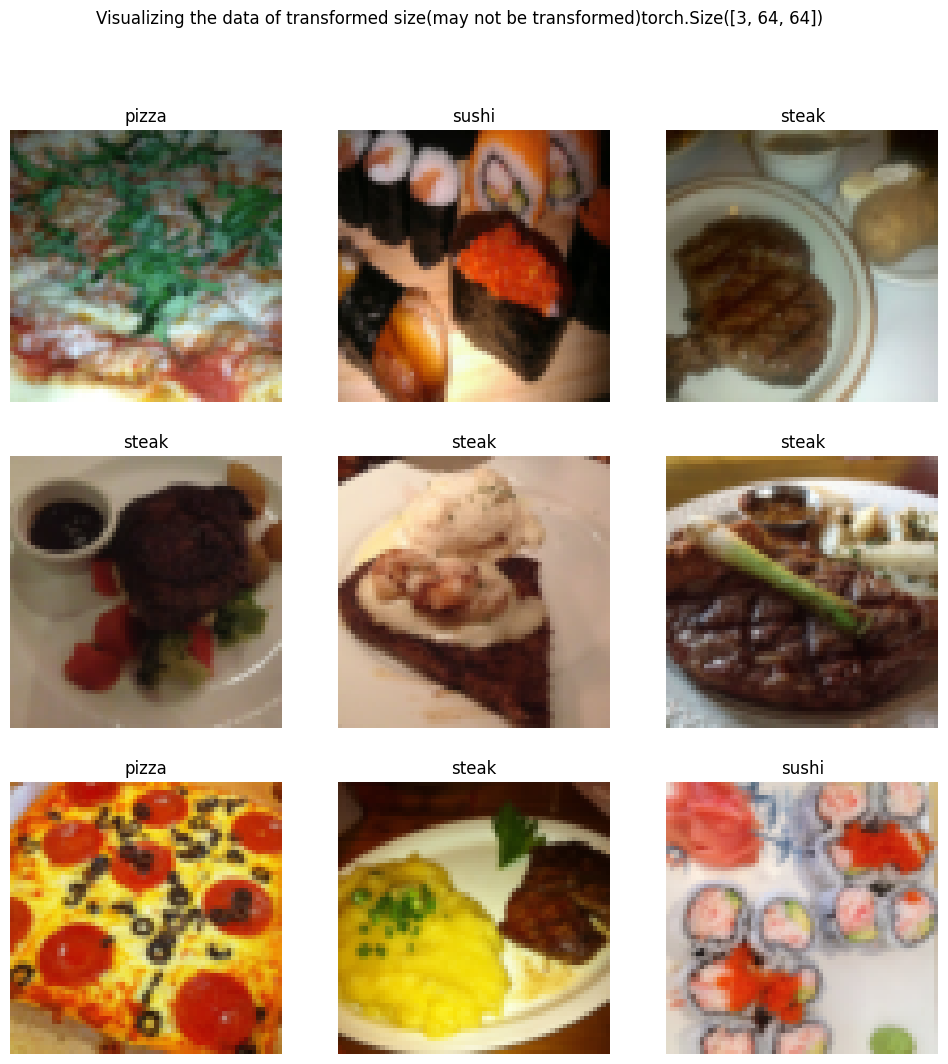

In [ ]:
visualize_9_img(train_data,42)

In [ ]:


def visualize_9_img_non_transformed(data,seed=None):
  if seed:
    torch.manual_seed(seed)
  rows,cols=3,3
  i=1
  plt.figure(figsize=(12,12))
  samples=torch.randint(0,len(data),size=[9])
  for sample in samples:
    # img,label=data[sample]
    plt.subplot(rows,cols,i)
    img=data.load_image(sample)
    
    # img.show() #shows img one by one and non transformed imgs
    plt.imshow(img) #shows in grid format or subplots of (rows*cols)

    plt.title(f"{class_names[label]},{img.size}")
    plt.suptitle("Visualizing the data",fontsize=24)
    plt.axis(False);
    i+=1


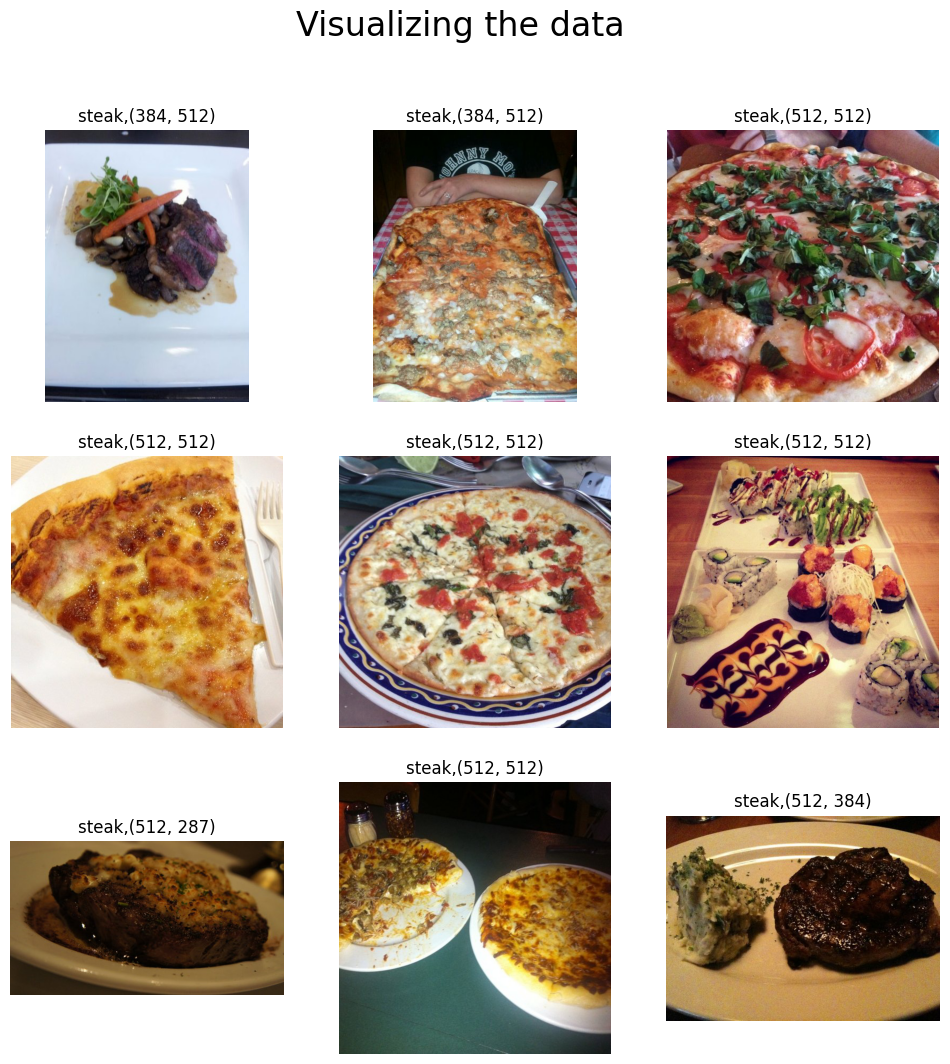

In [ ]:
visualize_9_img_non_transformed(train_data_custom)

##convert the train and test data custom into the dataloaders!!

In [ ]:
from torch.utils.data import DataLoader
train_custom_dataloader=DataLoader(train_data_custom,1,shuffle=True)

test_custom_dataloader=DataLoader(test_data_custom,1,shuffle=False)

In [ ]:
train_custom_dataloader,test_custom_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f69af608d60>,
 <torch.utils.data.dataloader.DataLoader at 0x7f6a5ac7bdf0>)

In [ ]:
#custom data
len(train_custom_dataloader),len(test_custom_dataloader)

(225, 75)

In [ ]:
#original data
len(train_dataloader),len(test_dataloader)

(225, 75)

In [ ]:
img,label=next(iter(train_custom_dataloader))

steak


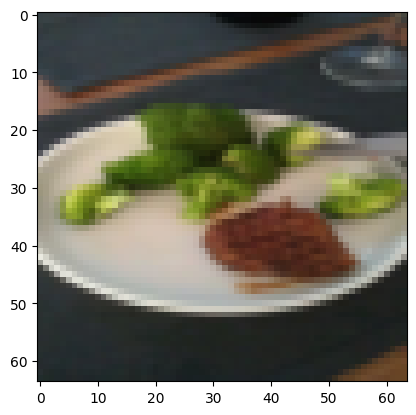

In [ ]:
#CUstom data
plt.imshow(img.squeeze().permute(1,2,0))
print(class_names[label])

In [ ]:
#original data
img,label=next(iter(train_dataloader))

steak


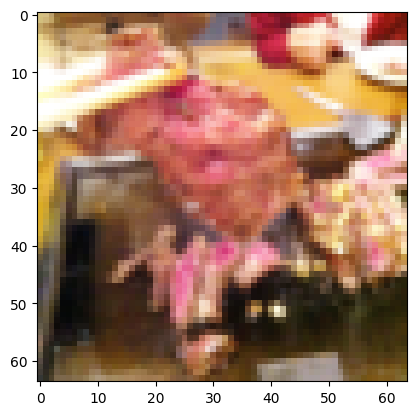

In [ ]:
plt.imshow(img.squeeze().permute(1,2,0))
print(class_names[label])

In [ ]:
#Going to Augmentation of data


## 6. Data Augmentation

Process of artificially adding diversity to our training data

In the case of image data,this may mean applying diff image transformatios to the training images.

For audio it may be about adding noise in bg or distorting or changing the pitch

Its really helpful when we have lack of data or face the problem of overfitting

Wiki def:
 

- Data augmentation is a technique in machine learning used to reduce overfitting when training a machine learning model, by training models on several slightly-modified copies of existing data.

This practice hopefully resutls in model which is more generalizable

Let's take a look at one particular type of the data augmentation used o train Pytorch vision models to the state of the art levels...


error in the FiveCrop method
https://stackoverflow.com/questions/66837824/pic-should-be-pil-image-or-ndarray-got-class-tuple

In [ ]:
  #Lets look at trivial augment

from torchvision import transforms
train_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])


In [ ]:
#Get all paths
image_path_list=list(image_path.glob("*/*/*.jpg"))

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

<Figure size 1200x1000 with 0 Axes>

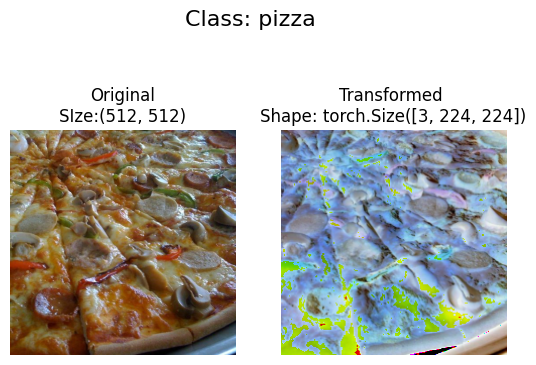

<Figure size 1200x1000 with 0 Axes>

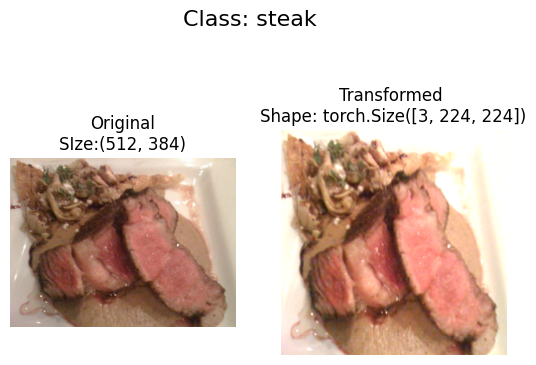

<Figure size 1200x1000 with 0 Axes>

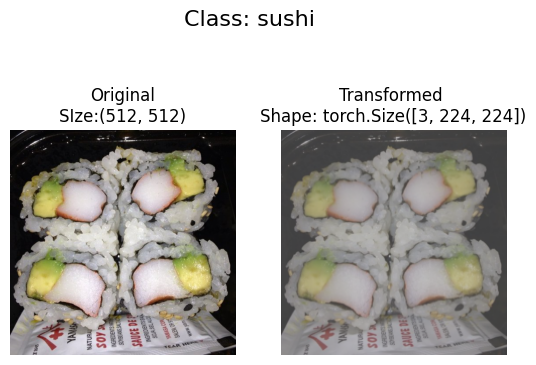

In [ ]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

In [ ]:
train_data_custom=ImageFolderCustom(train_dir,
                                    train_transform)

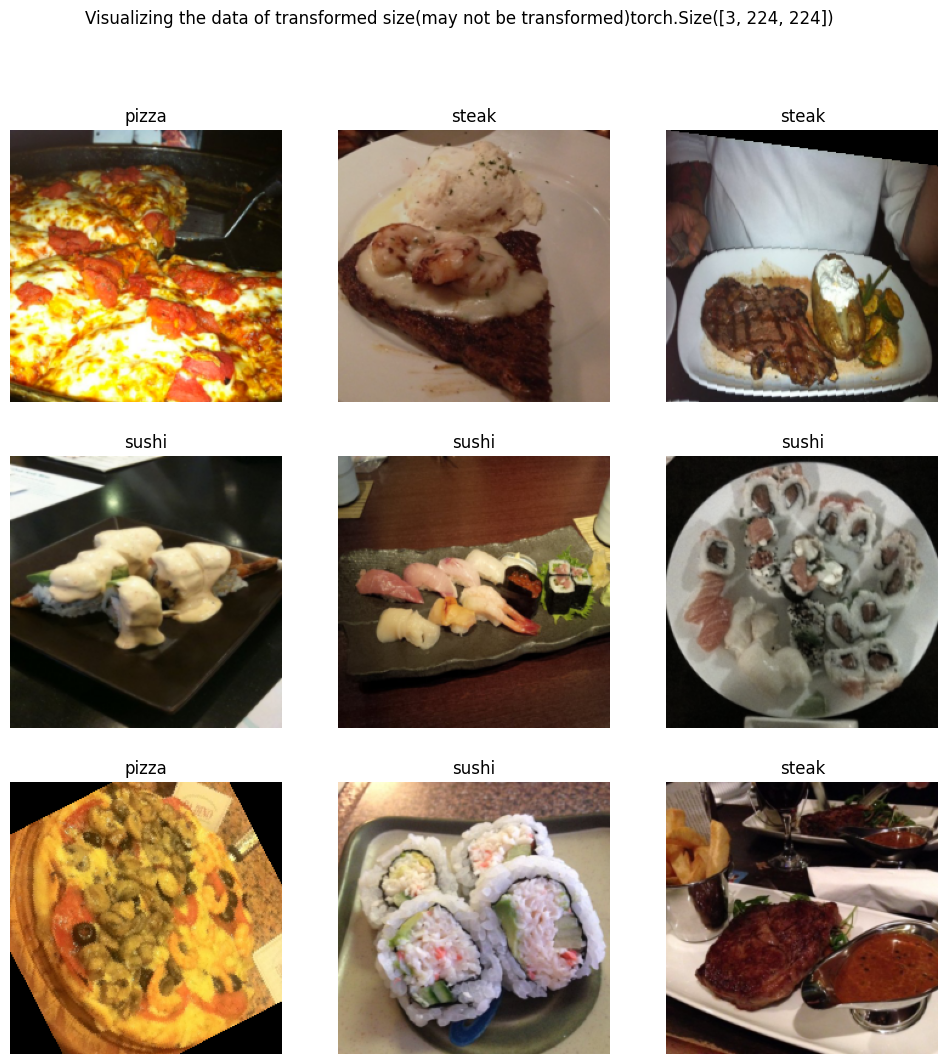

In [ ]:
visualize_9_img(train_data_custom,seed=42)

## 7. Model 0:TinyVGG without data augmentation

Let's replicate the TInyVGG architecture from the CNN Explainer Website

### 7.1 Creating the transform anf loading the data for Model 0 

In [ ]:
#Create simple transform
simple_transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [ ]:
train_dir=image_path/ "train"
test_dir=image_path/ "test"
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
image_path_list=list(image_path.glob("*/*/*.jpg"))
image_path_list[0]

PosixPath('data/pizza_steak_sushi/train/pizza/2451169.jpg')

In [ ]:
from torchvision.datasets import ImageFolder
train_data=ImageFolder(train_dir,
                       simple_transform)

test_data=ImageFolder(test_dir,
                       simple_transform)

In [ ]:
train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [ ]:
from torch.utils.data import DataLoader

train_DataLoader_simple=DataLoader(train_data,32,shuffle=True)

test_DataLoader_simple=DataLoader(test_data,32,shuffle=True)

In [ ]:
len(train_DataLoader_simple),len(test_DataLoader_simple)

(8, 3)

In [ ]:
train_DataLoader_simple.dataset,test_DataLoader_simple.dataset

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [ ]:
from torch import nn
##Building the model
model_0=nn.Sequential(nn.Conv2d(in_channels=3, #b1
                                out_channels=20,
                                kernel_size=3,
                                stride=1,
                                padding=0),
                      nn.ReLU(),
                      
                      nn.Conv2d(in_channels=20,
                                out_channels=20,
                                kernel_size=3,
                                stride=1,
                                padding=0),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2),


                      nn.Conv2d(in_channels=20, #b2
                                out_channels=20,
                                kernel_size=3,
                                stride=1,
                                padding=0),
                      nn.ReLU(),
                      
                      nn.Conv2d(in_channels=20,
                                out_channels=20,
                                kernel_size=3,
                                stride=1,
                                padding=0),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2),


                      # nn.Conv2d(in_channels=20, #b3
                      #           out_channels=20,
                      #           kernel_size=3,
                      #           stride=1,
                      #           padding=1),
                      # nn.ReLU(),
                      
                      # nn.Conv2d(in_channels=20,
                      #           out_channels=20,
                      #           kernel_size=3,
                      #           stride=1,
                      #           padding=0),
                      # nn.ReLU(),
                      # nn.MaxPool2d(kernel_size=2),

                      nn.Flatten(),
                      nn.Linear(in_features=3380 #To calc this do C*W*H
                                ,out_features=len(class_names))
                     ).to(device)







In [ ]:
# class tinyVGG(nn.Module):
#   self.conv1_1=nn.Sequential(
#       nn.L
#   )

In [ ]:
model_0

Sequential(
  (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=3380, out_features=3, bias=True)
)

### 7.3 Try a forward pass on a simgle image(to test the model)



In [ ]:
#Get a single image batch
image_batch,label_batch=next(iter(test_DataLoader_simple))
image_batch.shape,label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
model_0(image_batch)

tensor([[-0.0508, -0.0127, -0.0309],
        [-0.0449, -0.0106, -0.0319],
        [-0.0488, -0.0168, -0.0255],
        [-0.0503, -0.0208, -0.0335],
        [-0.0554, -0.0150, -0.0360],
        [-0.0543, -0.0083, -0.0241],
        [-0.0561, -0.0114, -0.0399],
        [-0.0500, -0.0083, -0.0230],
        [-0.0415, -0.0070, -0.0231],
        [-0.0413, -0.0078, -0.0189],
        [-0.0443, -0.0046, -0.0257],
        [-0.0497, -0.0133, -0.0363],
        [-0.0442, -0.0093, -0.0243],
        [-0.0451, -0.0052, -0.0280],
        [-0.0418, -0.0064, -0.0178],
        [-0.0498, -0.0069, -0.0243],
        [-0.0540, -0.0148, -0.0280],
        [-0.0477, -0.0099, -0.0240],
        [-0.0482, -0.0024, -0.0251],
        [-0.0411, -0.0097, -0.0375],
        [-0.0474, -0.0113, -0.0290],
        [-0.0443, -0.0047, -0.0221],
        [-0.0500, -0.0175, -0.0329],
        [-0.0549, -0.0102, -0.0343],
        [-0.0448, -0.0006, -0.0182],
        [-0.0382, -0.0110, -0.0297],
        [-0.0477, -0.0192, -0.0309],
 

In [ ]:
#units*W*H
10*13*13

1690

In [ ]:
!pip install -q torchinfo
!pip install -q torchmetrics
batch_size=32

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 11.8 MB/s eta 0:00:00


### 7.4 Use the `torchinfo` for getting info of our model

In [ ]:
from torchmetrics import Accuracy
acc=Accuracy(task="multiclass",num_classes=10)

In [ ]:
from torchinfo import summary

summary(model_0,input_size=(1,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 3]                    --
├─Conv2d: 1-1                            [1, 20, 62, 62]           560
├─ReLU: 1-2                              [1, 20, 62, 62]           --
├─Conv2d: 1-3                            [1, 20, 60, 60]           3,620
├─ReLU: 1-4                              [1, 20, 60, 60]           --
├─MaxPool2d: 1-5                         [1, 20, 30, 30]           --
├─Conv2d: 1-6                            [1, 20, 28, 28]           3,620
├─ReLU: 1-7                              [1, 20, 28, 28]           --
├─Conv2d: 1-8                            [1, 20, 26, 26]           3,620
├─ReLU: 1-9                              [1, 20, 26, 26]           --
├─MaxPool2d: 1-10                        [1, 20, 13, 13]           --
├─Flatten: 1-11                          [1, 3380]                 --
├─Linear: 1-12                           [1, 3]                    10,143
T

In [ ]:
#setting loss fun and optimizer

loss_fn=nn.CrossEntropyLoss()
opti=torch.optim.SGD(model_0.parameters(),lr=0.03)

In [ ]:
#training and test func

def train_model(model,
                data,
                loss_fn,
                opti
                ):
    train_loss=0
    train_acc=0
    loss=0
    accy=0
  # torch.autograd.set_detect_anomaly(True)
    for X,y in data:
      model.train()
      pred=model(X)
      loss=loss_fn(pred,y)
      train_loss+=loss.item()
      accy=acc(pred.argmax(dim=1),y)
      train_acc+=accy
      opti.zero_grad()
      loss.backward()
      opti.step()
      

    train_loss/=len(data)
    train_acc/=len(data)
    return train_loss,train_acc

    # print(f"Train_loss: {train_loss:.5f} | Train_acc: {train_acc:.2f}")
    # return l,a
  
def test_model(model,
                data,
                loss_fn
                ):
  
    test_loss=0
    test_acc=0
    loss=0
    accy=0
    model.eval()
    with torch.inference_mode():

      for X,y in data:
        pred=model(X)
        loss=loss_fn(pred,y)
        test_loss+=loss.item()
        accy=acc(pred.argmax(dim=1),y)
        test_acc+=accy

      test_loss/=len(data)
      test_acc/=len(data)
    return test_loss,test_acc
    
    # print(f"Test_loss: {test_loss:.5f} | Test_acc: {test_acc:.2f}")





In [ ]:
# torch.manual_seed(42)
# l,t_l=train_model(model_0,train_DataLoader_simple,loss_fn,opti,15)

In [ ]:
test_l,test_a=test_model(model_0,train_DataLoader_simple,loss_fn)

In [ ]:
# t_l

In [ ]:
from pathlib import Path
import requests
helper=Path("helper_functions.py")
request=requests.get("https://github.com/MananShukla7/Colab-Notebook/raw/main/helper_functions.py")
if helper.is_file():
  print("Alreday exists")
else:
  print("Creating")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

Alreday exists


In [ ]:
import helper_functions as h


In [ ]:
# h.lossfn_curve(l,15)
# plt.legend(["Train","Acc"])
# plt.show()
     


In [ ]:
# h.lossfn_curve(t_l,15)


In [ ]:
def train_m(model,
          data,
          test_data,
          loss_fn,
          opti,
          epochs
          ):
  torch.manual_seed(42)
  result={"train_loss":[],
          "test_loss":[],
          "train_acc":[],
          "test_acc":[]
          }
  for epoch in tqdm(range(epochs)):
    print(f"Epoch : {epoch}\n---------")
    train_loss,train_acc=train_model(model,data,loss_fn,opti)

    test_loss,test_acc=test_model(model,test_data,loss_fn)
    

    print(f"Train_loss: {train_loss:.5f} | Train_acc: {train_acc:.2f} | Test_loss: {test_loss:.5f} | Test_acc: {test_acc:.2f}")
    result["train_loss"].append(train_loss)
    result["test_loss"].append(test_loss)
    result["train_acc"].append(train_acc)
    result["test_acc"].append(test_acc)

  return result
  

In [ ]:
import tqdm
from tqdm.auto import tqdm

In [ ]:
results=train_m(model_0,
          train_DataLoader_simple,
          test_DataLoader_simple,
          loss_fn,
          opti,
          15
          )

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 0
---------
Train_loss: 1.08638 | Train_acc: 0.43 | Test_loss: 1.11435 | Test_acc: 0.26
Epoch : 1
---------
Train_loss: 1.08638 | Train_acc: 0.43 | Test_loss: 1.10120 | Test_acc: 0.34
Epoch : 2
---------
Train_loss: 1.10689 | Train_acc: 0.30 | Test_loss: 1.09816 | Test_acc: 0.36
Epoch : 3
---------
Train_loss: 1.08638 | Train_acc: 0.43 | Test_loss: 1.09800 | Test_acc: 0.36
Epoch : 4
---------
Train_loss: 1.10589 | Train_acc: 0.30 | Test_loss: 1.10137 | Test_acc: 0.34
Epoch : 5
---------
Train_loss: 1.10689 | Train_acc: 0.30 | Test_loss: 1.09816 | Test_acc: 0.36
Epoch : 6
---------
Train_loss: 1.10689 | Train_acc: 0.30 | Test_loss: 1.10441 | Test_acc: 0.32
Epoch : 7
---------
Train_loss: 1.08638 | Train_acc: 0.43 | Test_loss: 1.10457 | Test_acc: 0.32
Epoch : 8
---------
Train_loss: 1.10689 | Train_acc: 0.30 | Test_loss: 1.10810 | Test_acc: 0.30
Epoch : 9
---------
Train_loss: 1.08638 | Train_acc: 0.43 | Test_loss: 1.09800 | Test_acc: 0.36
Epoch : 10
---------
Train_loss: 1.10689

In [ ]:
model_0_res=results
model_0_res

{'train_loss': [1.086379386484623,
  1.0863793715834618,
  1.1068884134292603,
  1.0863793715834618,
  1.1058936268091202,
  1.1068883687257767,
  1.1068883836269379,
  1.086379386484623,
  1.1068883687257767,
  1.0863793566823006,
  1.106888398528099,
  1.0863794013857841,
  1.0863793417811394,
  1.0863793566823006,
  1.105893611907959],
 'test_loss': [1.114350398381551,
  1.1012048323949177,
  1.0981635649998982,
  1.098000208536784,
  1.1013681888580322,
  1.0981635252634685,
  1.1044096151987712,
  1.1045728921890259,
  1.1081043879191081,
  1.098000129063924,
  1.1044095754623413,
  1.1079409917195637,
  1.1015315850575764,
  1.0944688320159912,
  1.0946321487426758],
 'train_acc': [tensor(0.4258),
  tensor(0.4258),
  tensor(0.3047),
  tensor(0.4258),
  tensor(0.3047),
  tensor(0.3047),
  tensor(0.3047),
  tensor(0.4258),
  tensor(0.3047),
  tensor(0.4258),
  tensor(0.3047),
  tensor(0.4258),
  tensor(0.4258),
  tensor(0.4258),
  tensor(0.3047)],
 'test_acc': [tensor(0.2604),
  te

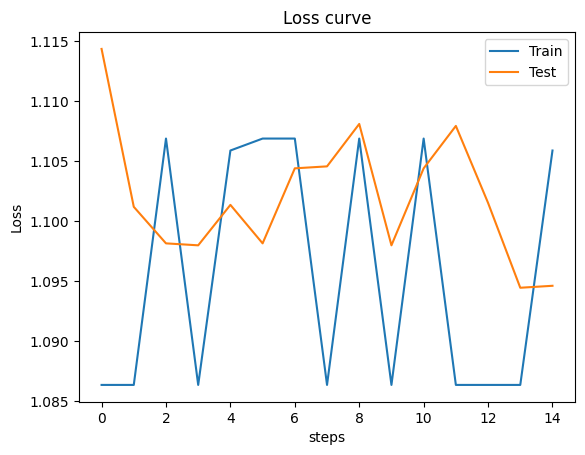

In [ ]:
h.lossfn_curve(model_0_res["train_loss"],15)
h.lossfn_curve(model_0_res["test_loss"],15)
plt.title("Loss curve")
plt.legend(["Train","Test"])
plt.show()


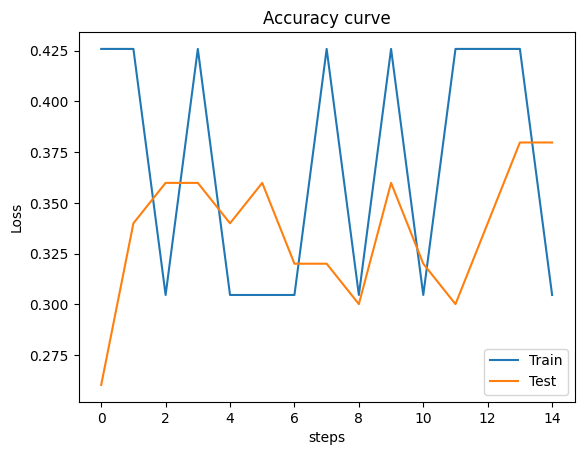

In [ ]:
h.lossfn_curve(model_0_res["train_acc"],15)
h.lossfn_curve(model_0_res["test_acc"],15)
plt.title("Accuracy curve")
plt.legend(["Train","Test"])
plt.show()


*Very good test and debug* https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

A large increase in loss is typically caused by anomalous values in input data. Possible causes are:

NaNs in input data.
Exploding gradient due to anomalous data.
Division by zero.
Logarithm of zero or negative numbers.
To fix an exploding loss, check for anomalous data in your batches, and in your engineered data. If the anomaly appears problematic, then investigate the cause. Otherwise, if the anomaly looks like outlying data, then ensure the outliers are evenly distributed between batches by shuffling your data.

##DRopout generalization

In [ ]:
scale=0

In [ ]:
import numpy as np
t=np.array([[ 0 , 1 , 2 , 3],
[ 4  ,5  ,6  ,7],
[ 8  ,9 ,10 ,11],
[12 ,13 ,14 ,15],
[16 ,17 ,18 ,19]])

mask = np.random.uniform(0, 1.0, t.shape) < 0.5
mask


array([[ True,  True,  True,  True],
       [ True, False,  True,  True],
       [ True,  True, False,  True],
       [ True, False, False,  True],
       [ True, False, False, False]])

In [ ]:
if 0.5 > 0.0:
        scale = (1/0.5)
else:
        scale = 0.0

mask * t * scale



array([[ 0.,  2.,  4.,  6.],
       [ 8.,  0., 12., 14.],
       [16., 18.,  0., 22.],
       [24.,  0.,  0., 30.],
       [32.,  0.,  0.,  0.]])

## 8. Modelling Tinyvgg using Data Augmentation

##Creating model 1!!
#setting loss fun and optimizer

loss_fn=nn.CrossEntropyLoss()
opti=torch.optim.SGD(model_0.parameters(),lr=0.003)

In [ ]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=4096,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        # print(x.shape)

        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=64, 
                  output_shape=len(train_data.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_fea

In [ ]:
# from torch import nn
# ##Building the model
# hidden=64
# model_1=nn.Sequential(nn.Conv2d(in_channels=3, #b1
#                                 out_channels=hidden,
#                                 kernel_size=3,
#                                 stride=1,
#                                 padding=0),
#                       nn.ReLU(),
                      
#                       nn.Conv2d(in_channels=hidden,
#                                 out_channels=hidden,
#                                 kernel_size=3,
#                                 stride=1,
#                                 padding=0),
#                       nn.ReLU(),
#                       nn.MaxPool2d(kernel_size=2),


#                       nn.Conv2d(in_channels=hidden, #b2
#                                 out_channels=hidden,
#                                 kernel_size=3,
#                                 stride=1,
#                                 padding=0),
#                       nn.ReLU(),
                      
#                       nn.Conv2d(in_channels=hidden,
#                                 out_channels=hidden,
#                                 kernel_size=3,
#                                 stride=1,
#                                 padding=0),
#                       nn.ReLU(),
#                       nn.MaxPool2d(kernel_size=2),


#                       nn.Conv2d(in_channels=hidden, #b3
#                                 out_channels=hidden,
#                                 kernel_size=3,
#                                 stride=1,
#                                 padding=1),
#                       nn.ReLU(),
                      
#                       nn.Conv2d(in_channels=hidden,
#                                 out_channels=hidden,
#                                 kernel_size=3,
#                                 stride=1,
#                                 padding=0),
#                       nn.ReLU(),
#                       nn.MaxPool2d(kernel_size=2),

#                       nn.Flatten(),
#                       nn.Linear(in_features=1600 #To calc this do C*W*H
#                                 ,out_features=len(class_names))
#                      ).to(device)







In [ ]:
from torchvision import transforms
train_transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])


In [ ]:
##Create train and test datasets and dataloader using augmented data
from torchvision.datasets import ImageFolder
train_data=ImageFolder(train_dir,train_transform)
test_data=ImageFolder(test_dir,test_transform)
train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [ ]:
##DataLoaders
train_Dataloader_augmented=DataLoader(train_data,32,shuffle=True)
test_Dataloader_s=DataLoader(test_data,32,shuffle=False)
train_Dataloader_augmented.dataset,test_Dataloader_s.dataset

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [ ]:
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_fea

In [ ]:
#setting loss fun and optimizer

loss_fn=nn.CrossEntropyLoss()
opti=torch.optim.Adam(model_1.parameters(),lr=0.035)

In [ ]:

model_1_res=train_m(model_1,train_Dataloader_augmented,test_Dataloader_s,loss_fn,opti,16)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch : 0
---------
Train_loss: 6235.57645 | Train_acc: 0.41 | Test_loss: 67.88545 | Test_acc: 0.26
Epoch : 1
---------
Train_loss: 44.29997 | Train_acc: 0.42 | Test_loss: 17.57956 | Test_acc: 0.25
Epoch : 2
---------
Train_loss: 2.38659 | Train_acc: 0.30 | Test_loss: 1.18629 | Test_acc: 0.27
Epoch : 3
---------
Train_loss: 1.26852 | Train_acc: 0.43 | Test_loss: 1.12294 | Test_acc: 0.26
Epoch : 4
---------
Train_loss: 1.16617 | Train_acc: 0.30 | Test_loss: 1.10141 | Test_acc: 0.26
Epoch : 5
---------
Train_loss: 1.09534 | Train_acc: 0.43 | Test_loss: 1.08452 | Test_acc: 0.26
Epoch : 6
---------
Train_loss: 1.08963 | Train_acc: 0.43 | Test_loss: 1.09091 | Test_acc: 0.26
Epoch : 7
---------
Train_loss: 1.42364 | Train_acc: 0.42 | Test_loss: 1.10159 | Test_acc: 0.26
Epoch : 8
---------
Train_loss: 1.11985 | Train_acc: 0.30 | Test_loss: 1.11654 | Test_acc: 0.26
Epoch : 9
---------
Train_loss: 1.08403 | Train_acc: 0.43 | Test_loss: 1.12999 | Test_acc: 0.26
Epoch : 10
---------
Train_loss: 1

In [ ]:
model_1_res

{'train_loss': [6235.576451413333,
  44.29996928572655,
  2.386589616537094,
  1.2685224264860153,
  1.166168987751007,
  1.095341071486473,
  1.089626669883728,
  1.4236368909478188,
  1.1198463290929794,
  1.0840314701199532,
  1.1186451464891434,
  1.0872607603669167,
  1.0855269208550453,
  1.1116172671318054,
  1.1112892478704453,
  1.1027362793684006],
 'test_loss': [67.88545481363933,
  17.579558193683624,
  1.1862863699595134,
  1.122943600018819,
  1.1014058589935303,
  1.0845237970352173,
  1.0909126202265422,
  1.1015903949737549,
  1.1165440281232197,
  1.1299910346666973,
  1.13825128475825,
  1.120813210805257,
  1.1207124789555867,
  1.1208208799362183,
  1.1058581670125325,
  1.103200634320577],
 'train_acc': [tensor(0.4062),
  tensor(0.4219),
  tensor(0.3008),
  tensor(0.4297),
  tensor(0.3047),
  tensor(0.4258),
  tensor(0.4297),
  tensor(0.4219),
  tensor(0.3047),
  tensor(0.4258),
  tensor(0.3047),
  tensor(0.4258),
  tensor(0.4258),
  tensor(0.3047),
  tensor(0.304

ValueError: ignored

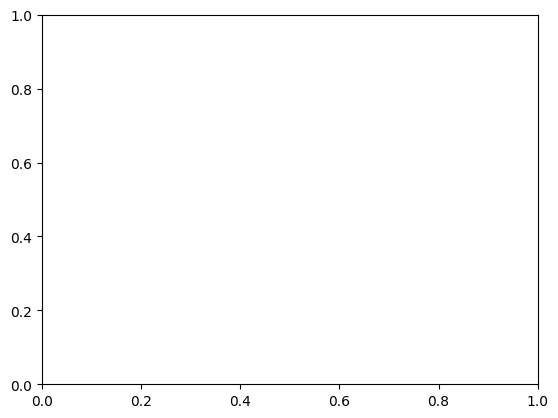

In [ ]:
h.lossfn_curve(model_1_res["train_loss"],168)
h.lossfn_curve(model_1_res["test_loss"],168)
plt.title("Loss curve")
plt.legend(["Train","Test"])
plt.show()


##COmpare model results

Afteer evaluating our modelling experiments on their own, 
its imp to compare them to each other

There are diff ways to do this:
1. Hard coding(what we'are doin)
2. Pytorch tensorboard
3. Weights and biases - https://wandb.ai/site/experiment-tracking
4. MLflow- https://mlflow.org/ 


In [ ]:
import pandas as pd
model_0_df=pd.DataFrame(model_0_res)
model_0_df


train_loss  test_loss       train_acc        test_acc
0     1.086379   1.114350  tensor(0.4258)  tensor(0.2604)
1     1.086379   1.101205  tensor(0.4258)  tensor(0.3400)
2     1.106888   1.098164  tensor(0.3047)  tensor(0.3598)
3     1.086379   1.098000  tensor(0.4258)  tensor(0.3598)
4     1.105894   1.101368  tensor(0.3047)  tensor(0.3400)
5     1.106888   1.098164  tensor(0.3047)  tensor(0.3598)
6     1.106888   1.104410  tensor(0.3047)  tensor(0.3201)
7     1.086379   1.104573  tensor(0.4258)  tensor(0.3201)
8     1.106888   1.108104  tensor(0.3047)  tensor(0.3002)
9     1.086379   1.098000  tensor(0.4258)  tensor(0.3598)
10    1.106888   1.104410  tensor(0.3047)  tensor(0.3201)
11    1.086379   1.107941  tensor(0.4258)  tensor(0.3002)
12    1.086379   1.101532  tensor(0.4258)  tensor(0.3400)
13    1.086379   1.094469  tensor(0.4258)  tensor(0.3797)
14    1.105894   1.094632  tensor(0.3047)  tensor(0.3797)

In [ ]:
model_1_df=pd.DataFrame(model_1_res)
model_1_df

train_loss  test_loss       train_acc        test_acc
0   6235.576451  67.885455  tensor(0.4062)  tensor(0.2604)
1     44.299969  17.579558  tensor(0.4219)  tensor(0.2500)
2      2.386590   1.186286  tensor(0.3008)  tensor(0.2708)
3      1.268522   1.122944  tensor(0.4297)  tensor(0.2604)
4      1.166169   1.101406  tensor(0.3047)  tensor(0.2604)
5      1.095341   1.084524  tensor(0.4258)  tensor(0.2604)
6      1.089627   1.090913  tensor(0.4297)  tensor(0.2604)
7      1.423637   1.101590  tensor(0.4219)  tensor(0.2604)
8      1.119846   1.116544  tensor(0.3047)  tensor(0.2604)
9      1.084031   1.129991  tensor(0.4258)  tensor(0.2604)
10     1.118645   1.138251  tensor(0.3047)  tensor(0.2604)
11     1.087261   1.120813  tensor(0.4258)  tensor(0.2604)
12     1.085527   1.120712  tensor(0.4258)  tensor(0.2604)
13     1.111617   1.120821  tensor(0.3047)  tensor(0.2604)
14     1.111289   1.105858  tensor(0.3047)  tensor(0.2604)
15     1.102736   1.103201  tensor(0.3047)  tensor(0.2604)

In [ ]:
diff=model_1_df["train_loss"]-model_0_df["train_loss"]
diff

0     6234.490072
1       43.213590
2        1.279701
3        0.182143
4        0.060275
5       -0.011547
6       -0.017262
7        0.337258
8        0.012958
9       -0.002348
10       0.011757
11       0.000881
12      -0.000852
13       0.025238
14       0.005396
15            NaN
Name: train_loss, dtype: float64

##Prediction on the custom data!

It includes images not included in the train or test data and see how our model performs on that!

In [ ]:
# Download a custom imahe

import requests

custom_image_path=data_path/"04-pizza-dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path,"wb") as f:
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}... ")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists")

data/04-pizza-dad.jpeg already exists


##Loading the custom image with pytorch

Ensure that we have to make sure that our custom image is in the same foramt as the data our model was trained on:

things that we gotta keep in mind:
- image must be in tensor
-image size must be 64x64
-image must be on the right device!

In [ ]:
import torchvision

#Read custom image

custom_image_uint8=torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255

In [ ]:
custom_image_uint8

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

torch.Size([3, 4032, 3024])


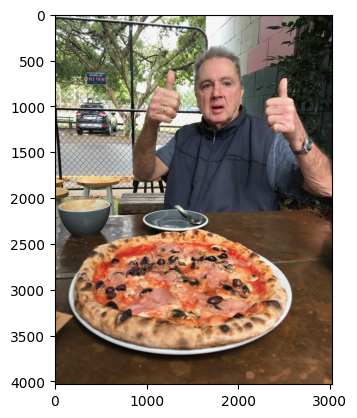

In [ ]:
plt.imshow(custom_image_uint8.permute(1,2,0));
print(custom_image_uint8.shape)

In [ ]:
trans_img=transforms.Resize(size=(64,64))

In [ ]:
transformed_custom_img=trans_img(custom_image_uint8)

torch.Size([3, 64, 64])


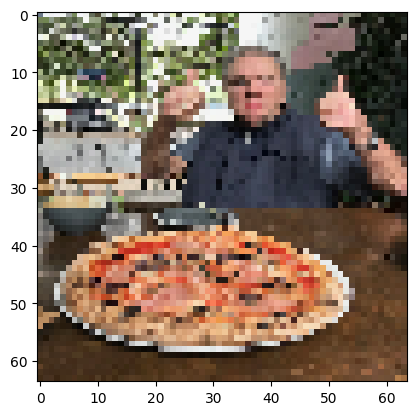

In [ ]:
plt.imshow(transformed_custom_img.permute(1,2,0));
print(transformed_custom_img.shape)

In [ ]:
model_1.eval()
with torch.inference_mode():
  custom_img_pred=model_1(transformed_custom_img.unsqueeze(dim=0))
custom_img_pred

tensor([[ 0.0563, -0.0265, -0.0163]])

In [ ]:
custom_img_pred.argmax(dim=1)

tensor([0])

In [ ]:
class_names[custom_img_pred.argmax(dim=1)]

'pizza'

In [ ]:
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x64 and 4096x3)
#error due

In [ ]:
#Writing custom func for this pred

def image_pred(img_path,model):
  img_path=str(img_path)
  img=torchvision.io.read_image(img_path).type(torch.float32) /255
  trans_img=transforms.Resize(size=(64,64))
  # plt.imshow(img.permute(1,2,0))
  img=trans_img(img)
  plt.imshow(img.permute(1,2,0))
  print(img.shape)
  # plt.imshow(img.permute(1,2,0))
  model.eval()
  with torch.inference_mode():
    img_pred=model(img.unsqueeze(dim=0))

  pred_label=img_pred.argmax(dim=1)
  class_n=class_names[pred_label]
  plt.title(f"Pred : {class_n} | Prob : {torch.max(img_pred.softmax(dim=1)).item():.3f}")
  plt.axis(False);

torch.Size([3, 64, 64])


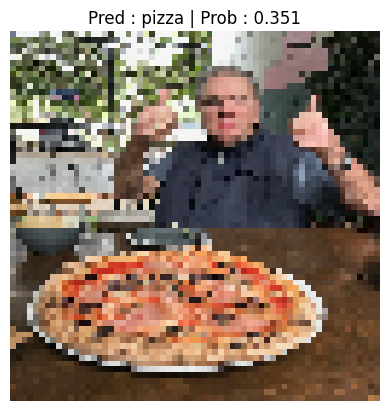

In [ ]:
image_pred(custom_image_path,model_1)

torch.Size([3, 64, 64])


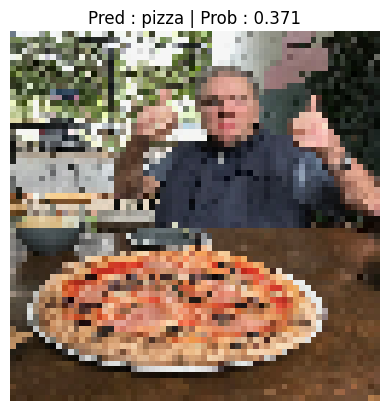

In [ ]:
image_pred(custom_image_path,model_0)